In [4]:
# import standard libraries
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import random
import time

# import our libraries
import bayes_helpers as bh
from utils import generate_data
from feed_forward import Feedforward
from nlm import NLM
from luna import LUNA

from config import *

### Generate 2D Categorical Data:
 - Sample 50 points from each normal distribution: $B_0 \sim N([3,3],I)$ and $B_1 \sim N([-3,3],I) $
 - Label $B_0$ points with prediction value 0, and $B_1$ with value 1.

In [28]:
def generate_log_data(random_seed,number_of_points=training_sample_size):
    
    random.seed(random_seed)
    blob_points = round(number_of_points/2)
    blob1 = np.random.multivariate_normal([3,3],np.identity(2),blob_points)
    blob2 = np.random.multivariate_normal([-3,-3],np.identity(2),blob_points)
    x_train = np.concatenate([blob1,blob2])
    y_train = np.array([0]*blob_points+[1]*blob_points)
    
    return x_train.T,y_train.reshape(1,-1)

x_train, y_train = generate_log_data(234)


### Train LUNA With Logistic Bayesian Regression

In [30]:
opt_params["max_iteration"] = 10000

In [31]:
t0 = time.time()
luna_architecture['input_dim'] =2

luna = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, luna_architecture, random_seed,logistic=True)
print(luna.ff.params)
luna.train(x_train, y_train, opt_params)
print(f"time: {np.round(time.time() - t0, 3)} seconds")

{'H': 50, 'L': 2, 'D_in': 2, 'D_out': 50, 'activation_type': 'relu', 'activation_params': 'rate=1'}
 Iteration 9900 lower bound 271.1942531233926; gradient mag: 214.838278630984185
Done Training
time: 11495.313 seconds


### Vizualize standard deviation and mean of posterior predictives across grid of inputs

sd


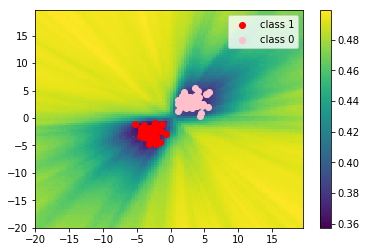

mean_pred


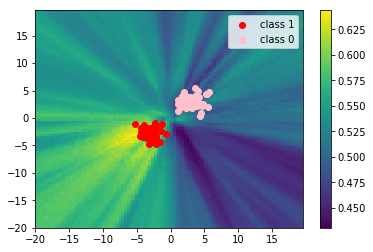

In [41]:
'''
luna is 2D luna object trained with a logistic model
x is N X 2 array
y is a 1 D array
'''
def viz_2D_pp_samples(luna, x, y):
    
    # plot test points
                
    # Create mesh
    interval = np.arange(-20, 20, 0.4)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)
    
    predictives, predictive_samples = luna.predict(xx.T)
    
    yy_sd = predictive_samples.std(axis = 0)
    
    mean_prediction = predictive_samples.mean(axis =0)
    
    for name, stat in {"sd":yy_sd,
                 "mean_pred":mean_prediction}.items():
        print(name)
        plt.pcolormesh(x1.reshape(n, n), 
                   x2.reshape(n, n), 
                   stat.reshape(n, n))

        plt.colorbar()

         # plto training points
        plt.scatter(x[y == 1, 0], x[y == 1, 1], c='red', label='class 1')
        plt.scatter(x[y == 0, 0], x[y == 0, 1], c='pink', label='class 0')
        plt.legend()
        plt.savefig(f"fig_scratch/luna2d_{name}.png")
        plt.show()
        

viz_2D_pp_samples(luna,x_train.T, y_train.flatten())
    